# NLP Tensorflow

# Imports

In [4]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/alana/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alana/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alana/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alana/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [5]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Import Data

In [6]:
dados = pd.read_csv('COURSERA/imdb_pt/imdb-reviews-pt-br.csv')
dados.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [7]:
data = dados[['text_pt','sentiment']]

In [8]:
data

,text_pt,sentiment
0,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,Este é um exemplo do motivo pelo qual a maiori...,neg
2,"Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...
49454,"Como a média de votos era muito baixa, e o fat...",pos
49455,O enredo teve algumas reviravoltas infelizes e...,pos
49456,Estou espantado com a forma como este filme e ...,pos
49457,A Christmas Together realmente veio antes do m...,pos


# NLTK

### Wordcloud

In [1]:
def nuvem_palavras(texto, coluna_texto,sentimento):
    
    # Separar nuvem por sentimento
    texto = texto.query(f"sentiment == '{sentimento}'")
    
    # Juntando todos os textos na mesma string
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    
    # Gerando a nuvem de palavras
    nuvem_palvras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    
    # Plotando nuvem de palavras
    plt.figure(figsize=(24,12))
    plt.imshow(nuvem_palvras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

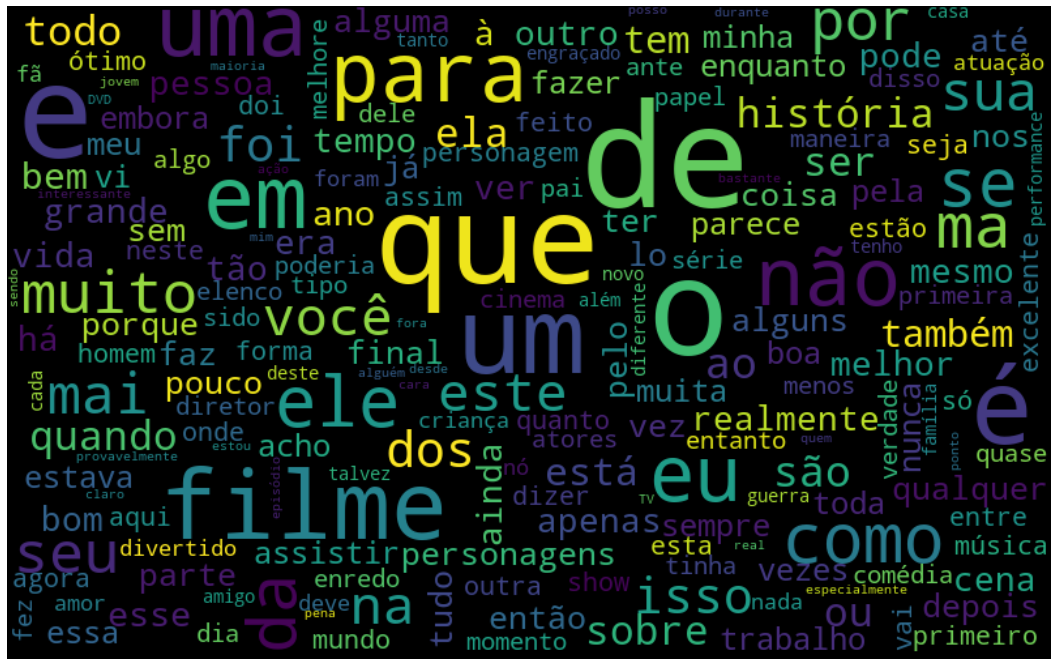

In [9]:
nuvem_palavras(data, "text_pt", "pos")

In [10]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [11]:
coluna_filtrada= list()

for frase in data.text_pt:
    nova_frase = list()
    palavras_texto = frase.split()
    
    for palavra in palavras_texto:
        if palavra not in stopwords:
            nova_frase.append(palavra)
    coluna_filtrada.append(' '.join(nova_frase))

# Sobrescrevendo a coluna text_pt
data.text_pt = coluna_filtrada

/home/alana/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
data

,text_pt,sentiment
0,"Mais vez, Sr. Costner arrumou filme tempo nece...",neg
1,Este exemplo motivo maioria filmes ação mesmos...,neg
2,"Primeiro tudo odeio raps imbecis, poderiam agi...",neg
3,Nem Beatles puderam escrever músicas todos gos...,neg
4,"Filmes fotos latão palavra apropriada eles, ve...",neg
...,...,...
49454,"Como média votos baixa, fato funcionário locad...",pos
49455,O enredo algumas reviravoltas infelizes inacre...,pos
49456,Estou espantado forma filme maioria outros méd...,pos
49457,A Christmas Together realmente veio antes temp...,pos


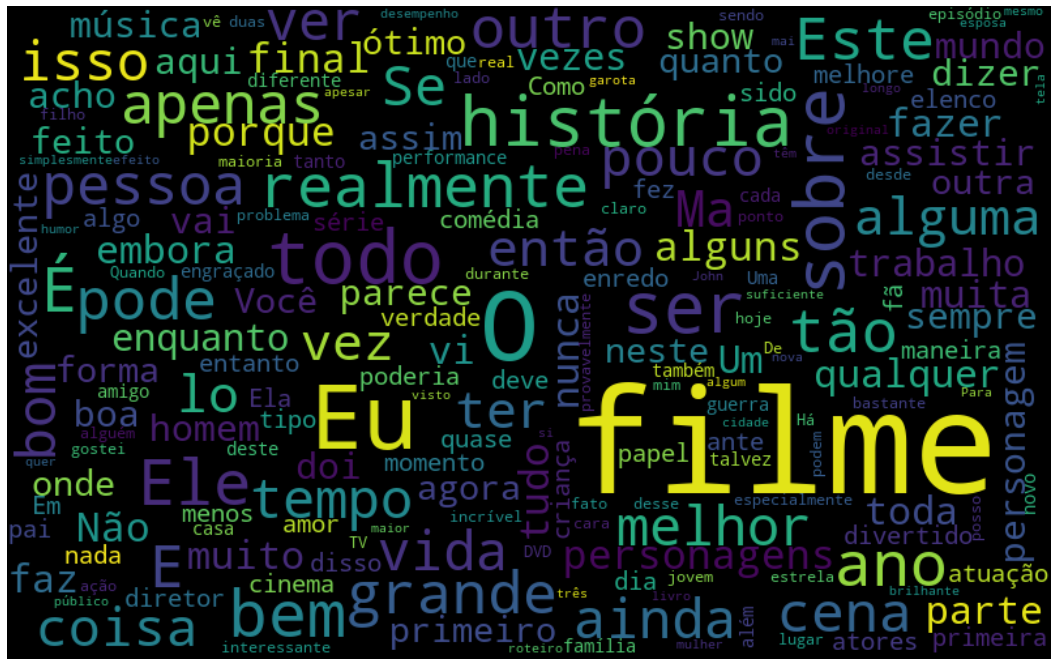

In [13]:
nuvem_palavras(data, "text_pt", "pos")

# Divisão em Treino e Teste

In [9]:
msk = np.random.rand(len(data)) < 0.7
train_data = data[msk]
test_data = data[~msk]

### Divisão sentences e labels

In [10]:
train_sentences, train_labels = train_data['text_pt'], train_data['sentiment']
test_sentences, test_labels = test_data['text_pt'], test_data['sentiment']

In [11]:
train_labels = train_labels.replace(['neg','pos'],[0,1])
test_labels = test_labels.replace(['neg','pos'],[0,1])

In [12]:
train_labels_final = np.array(train_labels)
test_labels_final = np.array(test_labels)

# Hiperparametros

In [13]:
vocab_size = 10000  #Tamanho do vocabulário
embedding_dim = 16   #Tamanho da dimensão
max_length = 120 # Tamanho do comprimento da sequencia de pad_sequences
trunc_type='post'
oov_tok = "<OOV>"

# Tokenizer

### Training

In [14]:
# Instanciar Tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)


# Função tokenizer para lista de frases
tokenizer.fit_on_texts(train_sentences)

# Substitui palavras fora do vocabulário durante as chamadas text_to_sequence (OOV)
word_index = tokenizer.word_index

# Transforma cada texto em uma sequência de inteiros.
sequences = tokenizer.texts_to_sequences(train_sentences)

# Transforma uma lista de sequências em uma matriz Numpy 2D
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

### Test

In [15]:
# Transforma cada texto em uma sequência de inteiros.
test_sentences = tokenizer.texts_to_sequences(test_sentences)

# Transforma uma lista de sequências em uma matriz Numpy 2D
testing_padded = pad_sequences(test_sentences,maxlen=max_length)

# Modelo Keras Bidirecional LSTM

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [17]:
num_epochs = 20
history = model.fit(padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels))

Epoch 1/20
1080/1080 [==============================] - 37s 34ms/step - loss: 0.4148 - accuracy: 0.7992 - val_loss: 0.3055 - val_accuracy: 0.8765
Epoch 2/20
1080/1080 [==============================] - 37s 35ms/step - loss: 0.2582 - accuracy: 0.8961 - val_loss: 0.3036 - val_accuracy: 0.8742
Epoch 3/20
1080/1080 [==============================] - 37s 34ms/step - loss: 0.2047 - accuracy: 0.9216 - val_loss: 0.3299 - val_accuracy: 0.8712
Epoch 4/20
1080/1080 [==============================] - 36s 33ms/step - loss: 0.1613 - accuracy: 0.9384 - val_loss: 0.3358 - val_accuracy: 0.8649
Epoch 5/20
1080/1080 [==============================] - 37s 34ms/step - loss: 0.1291 - accuracy: 0.9534 - val_loss: 0.3951 - val_accuracy: 0.8592
Epoch 6/20
1080/1080 [==============================] - 36s 34ms/step - loss: 0.1000 - accuracy: 0.9646 - val_loss: 0.5602 - val_accuracy: 0.8552
Epoch 7/20
1080/1080 [==============================] - 37s 34ms/step - loss: 0.0740 - accuracy: 0.9759 - val_loss: 0.5262 -

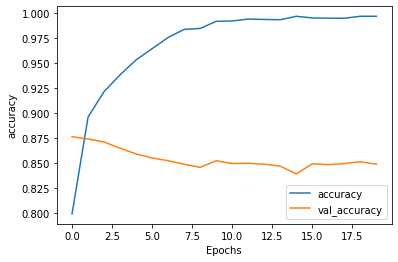

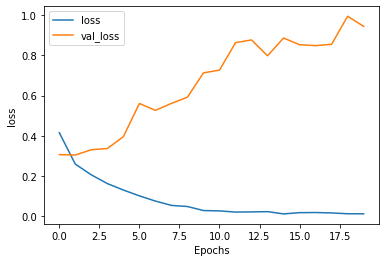

In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Save model

In [19]:
model.save('teste_model/4')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: teste_model/4/assets


In [4]:
model = keras.models.load_model('teste_model/4')